In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D


print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Version:",tf.__version__)

import matplotlib.pyplot as plt
import time

Num GPUs Available: 0
Version: 2.5.0-rc2


In [3]:
# Define hyper-parameters in advance

# Dropout rates in the network
DROPOUT_RATE_CONV = 0
DROPOUT_RATE_DENSE = 0.5

# Learning rate
LEARNING_RATE = 0.0001

# The number of batches
BATCH_SIZE = 32

# Number of epochs to run
EPOCHS = 150

# This can be "Iterative Improvement", "Target Accuracy", or "None"
END_CALLBACK = "Iterative Improvement"
# Either the accuracy we're aiming to hit on target accuracy mode, or the accuracy we want to start at with incremental improvement
DESIRED_ACCURACY = 0.9

# If it hasn't hit the desired accuracy after 1000 runs, it probably never will
if END_CALLBACK != "None":
  EPOCHS = 1000

In [2]:
# Import dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [3]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Create the testing dataset
testing_dataset=tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)

In [ ]:
# Augment the training data using a Keras ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale=None,
    fill_mode="nearest",
)

# Fit the data generator to the provided images (pre-computes transforms)
data_generator.fit(train_images)

In [4]:
# Architecture
model = Sequential([
    Conv2D(64, 3, activation='relu', input_shape=(32, 32, 3), padding='same'),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPooling2D(),
    BatchNormalization(),
    Dropout(DROPOUT_RATE_CONV),

    Conv2D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPooling2D(),
    BatchNormalization(),
    Dropout(DROPOUT_RATE_CONV),

    Conv2D(256, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(DROPOUT_RATE_CONV),
    Conv2D(256, 3, activation='relu', padding='same'),
    MaxPooling2D(),
    BatchNormalization(),
    Dropout(DROPOUT_RATE_CONV),

    Conv2D(512, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(DROPOUT_RATE_CONV),
    Conv2D(512, 3, activation='relu', padding='same'),
    MaxPooling2D(),
    BatchNormalization(),
    Dropout(DROPOUT_RATE_CONV),

    Flatten(),
    Dense(2048, activation='relu'),
    Dropout(DROPOUT_RATE_DENSE),
    BatchNormalization(),
    Dense(10, activation=keras.activations.softmax)
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        2

In [ ]:
def save_model(model, test_acc=DESIRED_ACCURACY):
    filepath = "tf-models/cifar10-classifier-"
    filepath += str(int(test_acc * 100))
    model.save(filepath)

In [6]:
#Compile model
# Instantiate an Adam optimizer with Nesterov momentum
optimiser = keras.optimizers.Nadam(learning_rate=LEARNING_RATE
# Enable GPU mixed precision
optimiser = keras.mixed_precision.LossScaleOptimizer(optimiser)

# Instantiate a loss object using Sparse Categorical Crossentropy
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile the model
model.compile(optimizer=optimiser, loss=loss, metrics=['accuracy'])

In [7]:
# Train the model

callbacks=None

next_target_accuracy = DESIRED_ACCURACY

if END_CALLBACK == "Target Accuracy":
    print("Using target accuracy of %f\%%" % (DESIRED_ACCURACY * 100.0))
    class AccuracyCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
          if (logs.get('val_accuracy') > DESIRED_ACCURACY):
            print("Stopping training as desired accuracy has been reached")
            self.model.stop_training = True

  callbacks = AccuracyCallback() 

elif END_CALLBACK == "Iterative Improvement":
    print("Using iterative improvement.  Initial target: %f%%" % (next_target_accuracy * 100.0))
    class IterativeImprovementCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            global next_target_accuracy
            if (logs.get('val_accuracy') > next_target_accuracy):
                print("Reached next milestone %f.  Saving and incrementing target by 1." % (next_target_accuracy))
                save_model(self.model, next_target_accuracy)
                next_target_accuracy += 0.01

    callbacks = IterativeImprovementCallback()

else:
    print("Not using callbacks")
    callbacks = keras.callbacks.Callback()
  

startTime = time.time()
history = model.fit(
    x=data_generator.flow(train_images, train_labels, BATCH_SIZE)
    , epochs=EPOCHS
    , steps_per_epoch=len(train_images)/BATCH_SIZE
    , validation_data=testing_dataset
    , callbacks=[callbacks]
)

finishTime = time.time()

Epoch 1/80
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpym0vxoxg.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpym0vxoxg.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
191/191 [==============================] - 33s 75ms/step - loss: 2.2392 - accuracy: 0.2637 - val_loss: 5.3708 - val_accuracy: 0.1000
Epoch 2/80
191/191 [==============================] - 12s 64ms/step - loss: 1.3123 - accuracy: 0.5172 - val_loss: 4.8571 - val_accuracy: 0.1056
Epoch 3/80
191/191 [==============================] - 12s 64ms/step - loss: 1.0154 - accuracy: 0.6324 - val_

In [8]:
#Print train time
timeTaken = finishTime - startTime
minutes = timeTaken // 60
seconds = round((timeTaken % 60), 1)
print(f"Time taken: {minutes}m, {seconds}s" )

Time taken: 16.0m, 26.9s


In [9]:
#Evaluate model with test set
test_loss, test_acc = model.evaluate(testing_dataset, verbose=2, batch_size=BATCH_SIZE)
print(f'\nTest accuracy: {round(test_acc *100, 2)}%')

20/20 - 1s - loss: 0.3332 - accuracy: 0.8923

Test accuracy: 89.23%


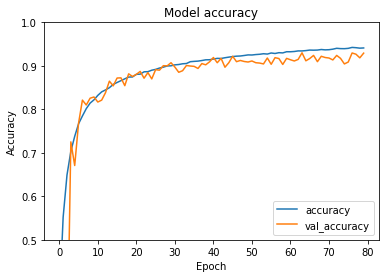

In [10]:
#Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

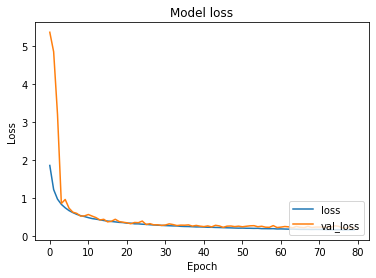

In [11]:
#Plot loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(loc='lower right')
plt.show()